In [ ]:
import data
from stable_baselines3 import PPO, SAC, DDPG
import random
import numpy as np
import environments
from environments import RastriginEnv
import torch
import matplotlib.pyplot as plt
import testing

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [5]:
training_functions = data.generate_dataset(n = 100, function_type = 'rastrigin_function', n_dims = 3)
testing_functions = data.generate_dataset(n = 10, function_type = 'rastrigin_function', n_dims = 3)

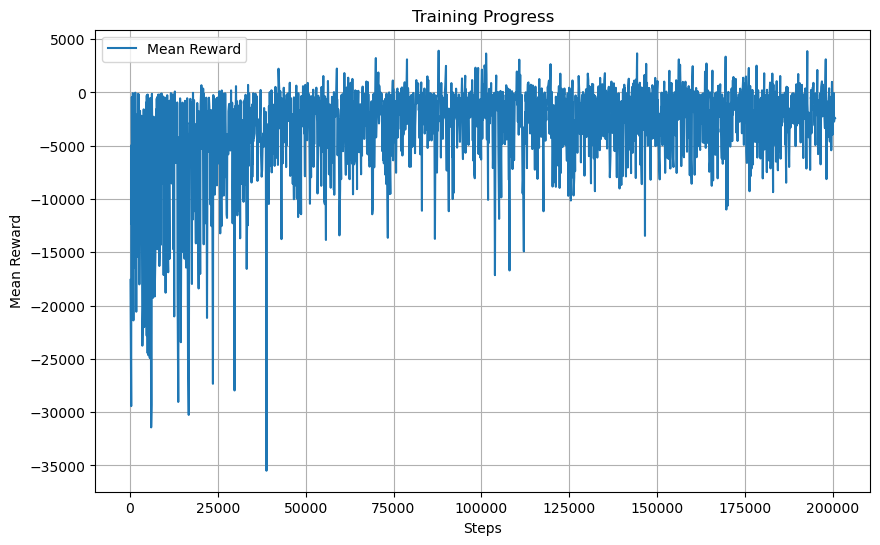

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 87.2         |
|    ep_rew_mean          | -1.66e+03    |
| time/                   |              |
|    fps                  | 198          |
|    iterations           | 98           |
|    time_elapsed         | 1010         |
|    total_timesteps      | 200704       |
| train/                  |              |
|    approx_kl            | 0.0050599636 |
|    clip_fraction        | 0.0249       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.64        |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.001        |
|    loss                 | 1.48e+04     |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.0192      |
|    std                  | 0.816        |
|    value_loss           | 6.55e+04     |
------------------------------------------


In [11]:
env = RastriginEnv(functions = training_functions, n_dims = 3, max_steps = 200, action_space = (-0.5,0.5))
model_ppo = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, device = device)
callback = environments.JupyterNotebookPlotCallback()
model_ppo.learn(total_timesteps=200000, callback=callback)

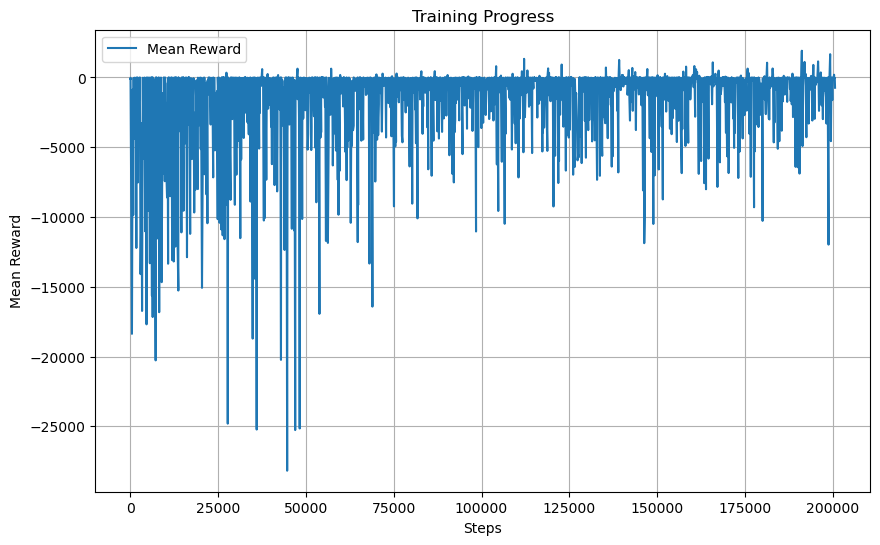

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 85.9        |
|    ep_rew_mean          | -579        |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 98          |
|    time_elapsed         | 1072        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.011813112 |
|    clip_fraction        | 0.0898      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.46       |
|    explained_variance   | 0.455       |
|    learning_rate        | 0.001       |
|    loss                 | 1.43e+04    |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.03       |
|    std                  | 0.766       |
|    value_loss           | 3.93e+04    |
-----------------------------------------


In [25]:
env = RastriginEnv(functions = training_functions, n_dims = 3, max_steps = 200, reward_type = 4)
model_ppo1 = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, device = device)
callback = environments.JupyterNotebookPlotCallback()
model_ppo1.learn(total_timesteps=200000, callback=callback)

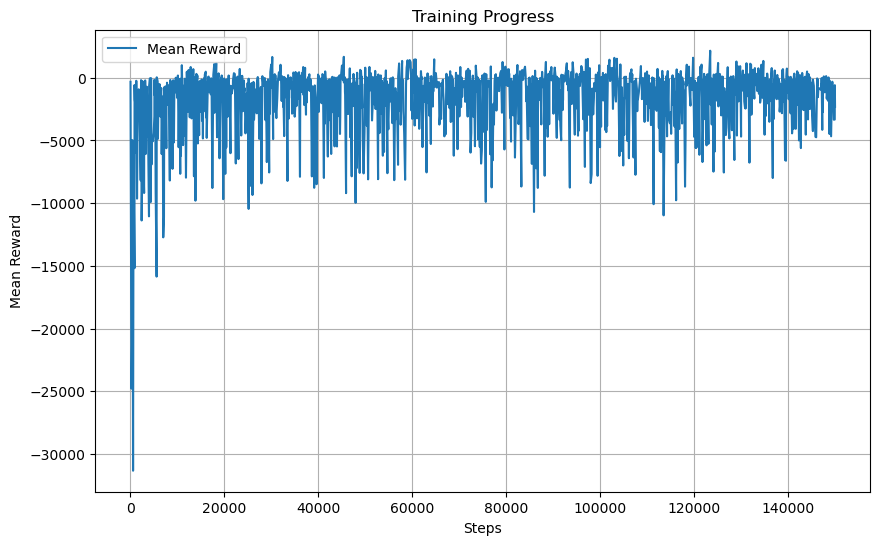

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 86.7      |
|    ep_rew_mean     | -1.18e+03 |
| time/              |           |
|    episodes        | 1704      |
|    fps             | 4         |
|    time_elapsed    | 30586     |
|    total_timesteps | 149961    |
| train/             |           |
|    actor_loss      | 1.53e+04  |
|    critic_loss     | 2.9e+06   |
|    ent_coef        | 7.52      |
|    ent_coef_loss   | 0.652     |
|    learning_rate   | 0.001     |
|    n_updates       | 149860    |
----------------------------------


In [13]:
env = RastriginEnv(functions = training_functions, n_dims = 3, max_steps = 200)
model_sac = SAC("MlpPolicy", env, verbose=1, learning_rate=1e-3, device = device)
callback = environments.JupyterNotebookPlotCallback()
model_sac.learn(total_timesteps=150000, callback=callback)

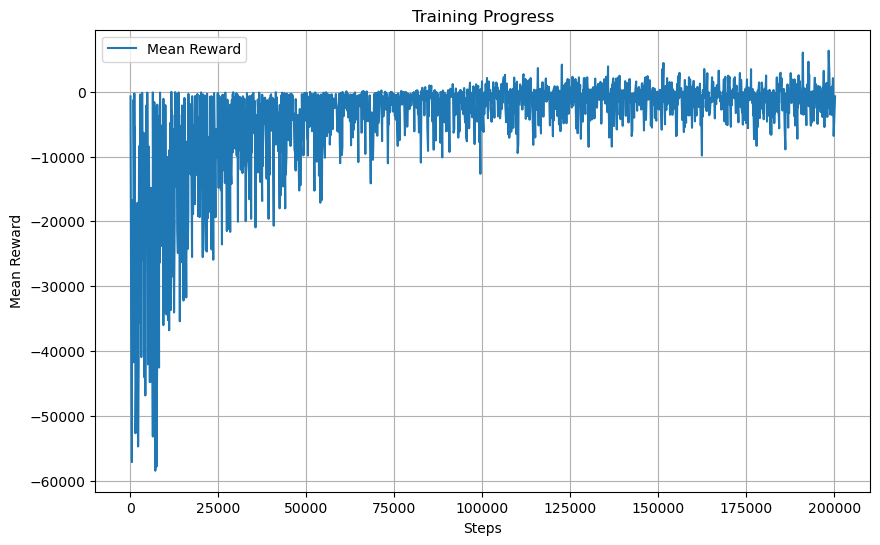

In [14]:
env = RastriginEnv(functions = training_functions, n_dims = 3, max_steps = 200)
model_ddpg = DDPG("MlpPolicy", env, verbose=1, learning_rate=1e-4, device = device)
callback = environments.JupyterNotebookPlotCallback()
model_ddpg.learn(total_timesteps=200000, callback=callback)

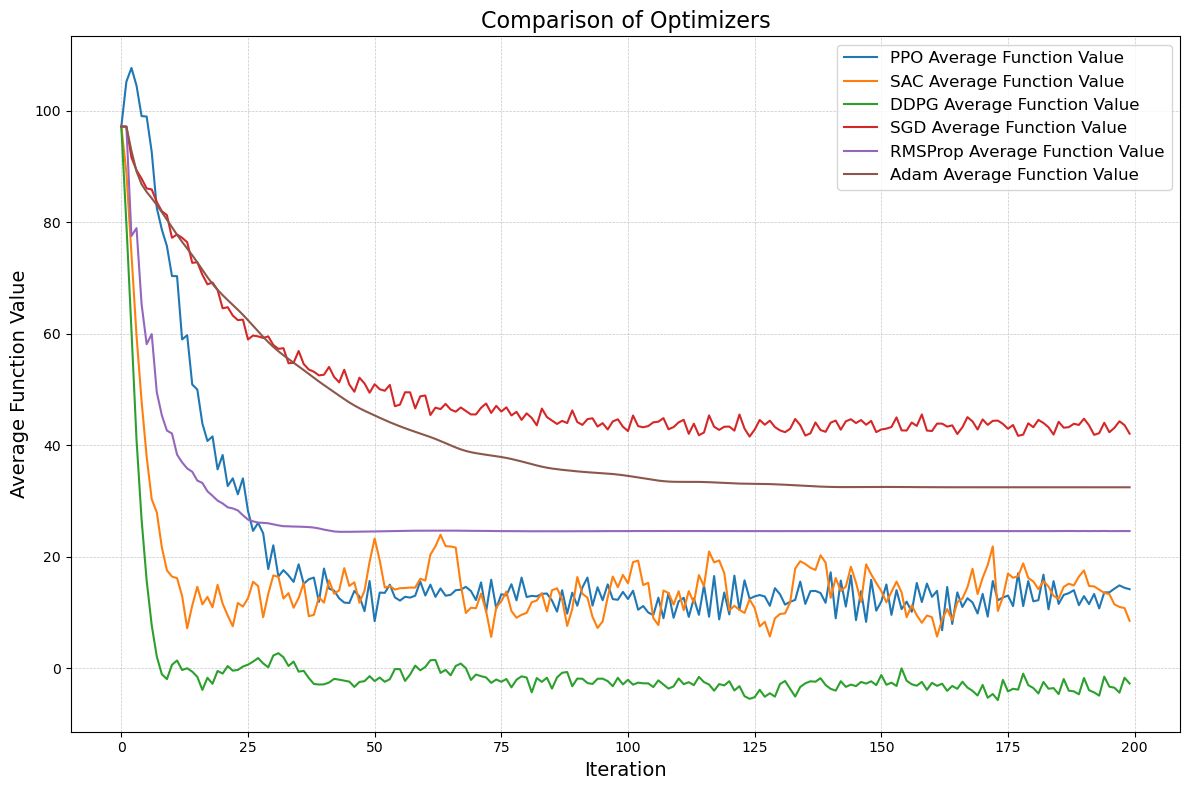

In [27]:
models = {
        'PPO': model_ppo,
        'SAC': model_sac,
        'DDPG': model_ddpg,
        'SGD': None,
        'RMSProp': None,
        'Adam': None,
    }
max_iterations = 200
results = testing.run_optimizer_tests(env, testing_functions, models, max_iterations = 200, function_type = 'rastrigin_function')
avg_values = testing.calculate_average_values(results)

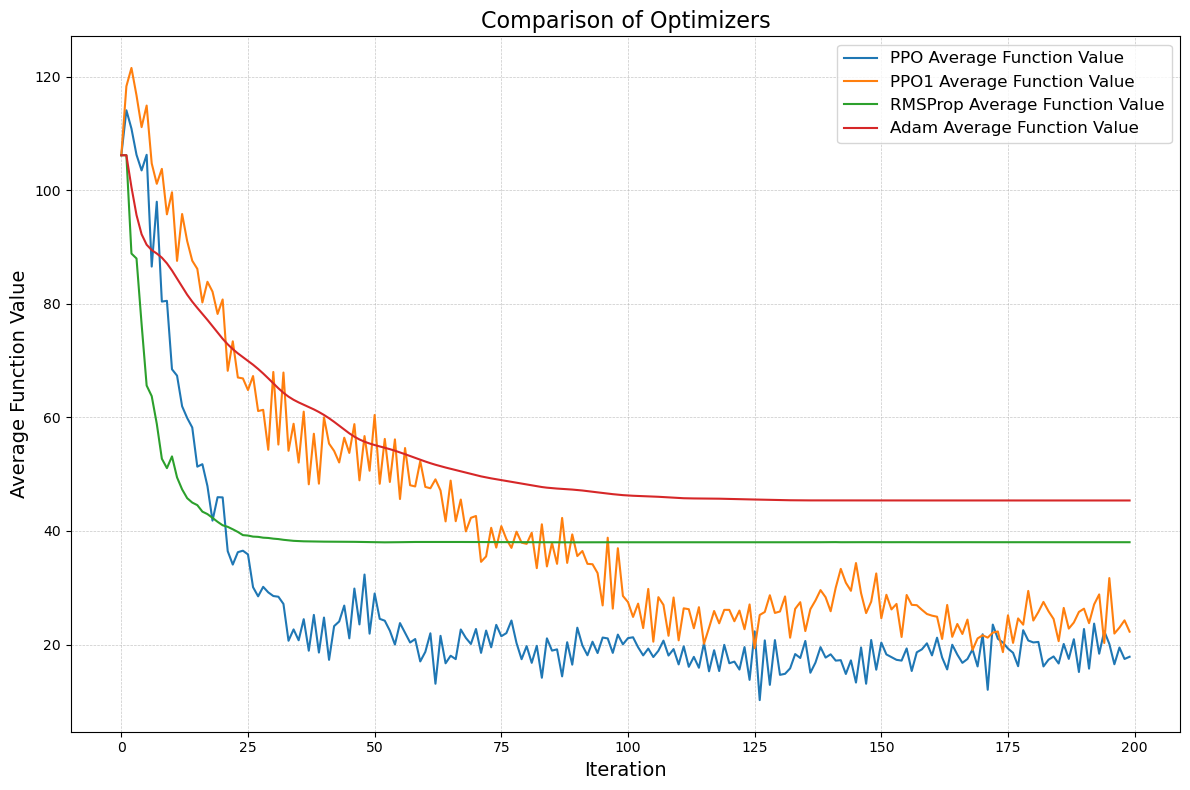

In [23]:
models = {
        'PPO': model_ppo,
        'PPO1': model_ppo1,
        'RMSProp': None,
        'Adam': None,
    }
max_iterations = 200
results = testing.run_optimizer_tests(env, testing_functions, models, max_iterations = 200, function_type = 'rastrigin_function')
avg_values = testing.calculate_average_values(results)
testing.plot_results(avg_values, max_iterations)

In [49]:
def plot_results(avg_values, max_iterations, save_path = None):
    """
    Plot optimization progress.
    """
    plt.figure(figsize=(12, 8))
    for model_name, values in avg_values.items():
        plt.plot(range(max_iterations), values, label=f"{model_name} Average Function Value")
    plt.title("Comparison of Optimizers", fontsize=16)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Average Function Value", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_final_function_values(comparison, save_path = None):
    """
    Plot a bar chart comparing the final function values across optimizers.

    Parameters:
    - comparison: List of tuples (model_name, final_function_value)
    """
    # Extract data for plotting
    optimizers = [item[0] for item in comparison]
    final_values = [item[1] for item in comparison]

    # Plot bar chart
    plt.figure(figsize=(12, 5))

    categories = {
        "RL-based": ["PPO", "SAC", "DDPG"],
        "Gradient-based": ["Adam", "RMSProp", "SGD"]
    }

    color_map = {
        "PPO": "blue",
        "SAC": "orange",
        "DDPG": "green",
        "Adam": "brown",
        "RMSProp": "purple",
        "SGD": "red"
    }

    bar_colors = [color_map.get(opt, "gray") for opt in optimizers]

    bars = plt.bar(optimizers, final_values, color = bar_colors, label="Final Function Value")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                 ha='center', va='bottom', fontsize=12)

    plt.xlabel("Optimizers")
    plt.ylabel("Final Average Function Values")
    plt.title("Final Accuracy Comparison Across Optimizers")
    plt.grid(False)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

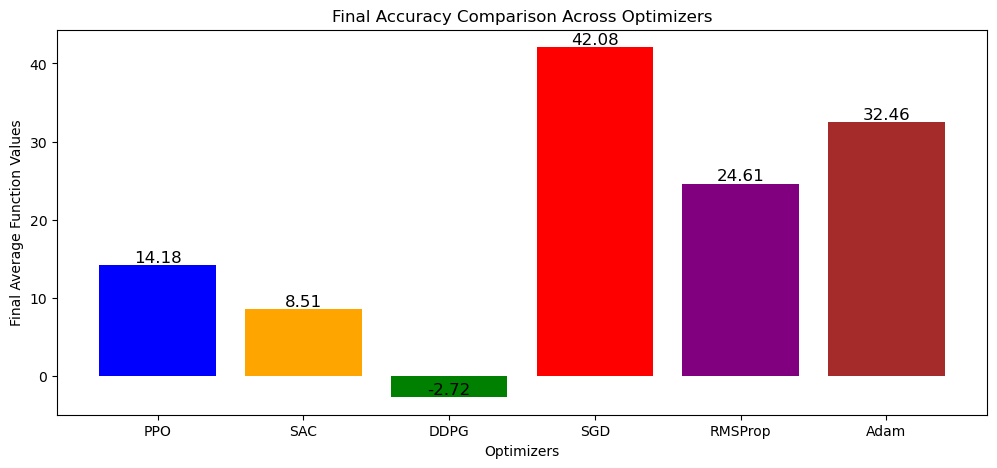

In [55]:
comparison = []
for model_name, data in avg_values.items():
    comparison.append((model_name, data[-1]))
plot_final_function_values(comparison, "Rastrigin_Function_Final_Accuracy")

In [57]:
model_ppo.save("Rastrigin_PPO")
print("PPO Agent saved successfully!")

model_sac.save("Rastrigin_SAC")
print("SAC Agent saved successfully!")

model_ddpg.save("Rastrigin_DDPG")
print("DDPG Agent saved successfully!")

PPO Agent saved successfully!
SAC Agent saved successfully!
DDPG Agent saved successfully!


In [59]:
train_env = RastriginEnv(functions = training_functions, n_dims = 3, max_steps = 200)
train_env_ppo = RastriginEnv(functions = training_functions, n_dims = 3, max_steps = 200, action_space = (-0.5,0.5))
ppo_agent = PPO.load("Rastrigin_PPO", env = train_env_ppo)
sac_agent = SAC.load("Rastrigin_SAC", env = train_env)
ddpg_agent = DDPG.load("Rastrigin_DDPG", env = train_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
